In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## 데이터셋 소개

- **데이터셋 정보**
    - [예나 날씨 데이터](https://www.kaggle.com/datasets/mnassrib/jena-climate)
    - **2009년부터 2016년까지** 독일 예나 도시의 날씨 데이터를 10분 간격으로 기록.
    - **14개 칼럼**: 기온(°C), 기압(hPa), 습도(%), 바람 속도 등 다양한 정보 포함.

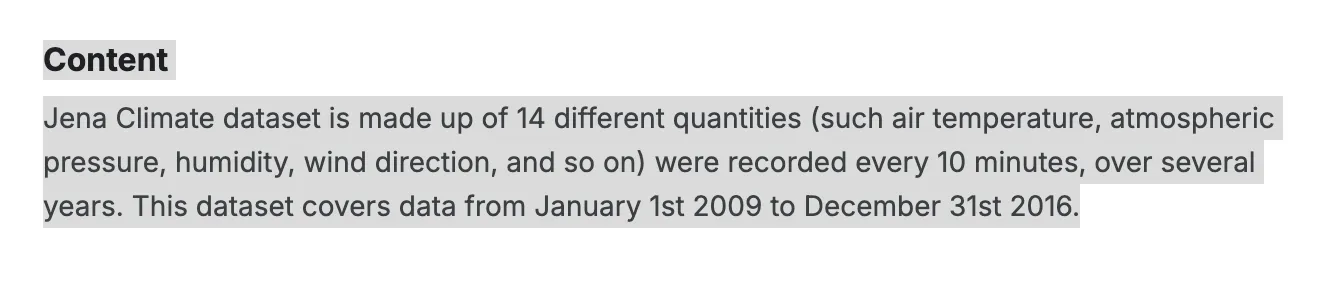  
- **예측 목표**
    - 주어진 길이의 **기온 시퀀스** 데이터를 활용해 **다음 시간의 기온**을 예측.

### 데이터 불러오기

In [17]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-06-11 22:27:28--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  54.7MB/s    in 0.2s    

2025-06-11 22:27:28 (54.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  


In [18]:
import pandas as pd

df = pd.read_csv('./jena_climate_2009_2016.csv')
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


- **칼럼 설명**
    - `Date Time`: 기록된 시간
    - `T (degC)`: 섭씨 온도
    - 기타 12개의 기상 요소 포함.

In [19]:
df.shape

(420551, 15)

- 총 데이터 개수: 약 **42만 개**
- 총 칼럼 수: **15개**

### 시각화

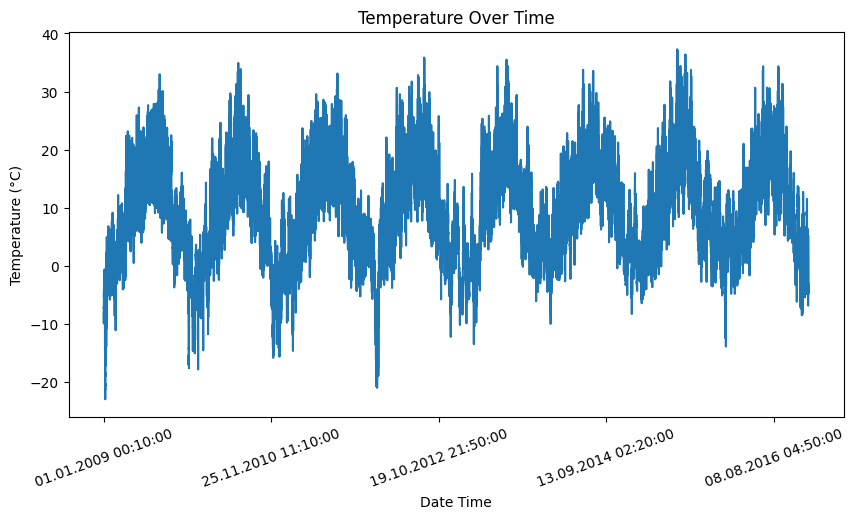

In [20]:
import matplotlib.pyplot as plt

temperatures = df['T (degC)']
temperatures.index = df['Date Time'] # 시간을 인덱스로 설정

plt.figure(figsize=(10, 5))  # 그래프 크기 조정
temperatures.plot()

plt.xticks(rotation=20)  # x축 눈금 회전 (예: 45도)
plt.xlabel("Date Time")  # x축 라벨 추가
plt.ylabel("Temperature (°C)")  # y축 라벨 추가
plt.title("Temperature Over Time")  # 제목 추가

plt.show()

- 계절성 패턴이 뚜렷하게 나타남:
    - 여름: 기온 상승.
    - 겨울: 기온 하강.
- **변동성**: 짧은 시간 간격에서도 기온 변동이 관측됨.

## 시계열 데이터 준비하기

### 데이터 처리

In [22]:
# @title to numpy
import numpy as np

temperatures = df[['T (degC)']].to_numpy().astype(np.float32)
temperatures = temperatures[:50000]

데이터프레임에서 기온 데이터를 numpy array 형식으로 변환

기온 정보 하나만 가져오는 거지만, 데이터 자체는 2차원으로 유지(대괄호를 두 개씩)

- 2차원으로 유지해야 뒤에서 데이터 표준화를 할 때 문제가 없음

In [25]:
# @title train/val/test split

num_data = len(temperatures)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temperatures[:train_size]
val_data = temperatures[train_size:train_size + val_size]
test_data = temperatures[train_size + val_size:]

In [27]:
# @title 표준화
print(f'max: {train_data.max()}, min: {train_data.min()}')

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

print(f'max: {train_data_scaled.max():.4f}, min: {train_data_scaled.min():.4f}')
print(f'mean: {train_data_scaled.mean():.4f}, std: {train_data_scaled.std():.4f}')

max: 32.97999954223633, min: -23.010000228881836
max: 2.6188, min: -3.8247
mean: 0.0000, std: 1.0000


In [28]:
# @title 데이터셋 객체 만들기
import torch
from torch.utils.data import Dataset

class JenaTemperatureDataset(Dataset):
    def __init__(self, temperatures, sequence_length):
      self.temperatures = temperatures
      self.sequence_length = sequence_length

    def __len__(self):
      #원본 데이터 개수에서 시퀀스 길이를 뺀 만큼
      return len(self.temperatures) - self.sequence_length

    def __getitem__(self, index):
      inputs = self.temperatures[index:index+self.sequence_length]
      targets = self.temperatures[index+1:index+self.sequence_length+1]

      return torch.tensor(inputs), torch.tensor(targets)


입력과 타깃 구조



- **입력**: 길이가 `sequence_length`인 시퀀스.
- **타깃**: 입력 데이터보다 한 타임스텝 뒤의 값.

 **예시**

```markdown

시퀀스 길이가 10이라면,
원본 시계열 데이터 : [t_0, t_1, t_2, ..., t_{N-1}]

**0번 데이터**
- Input:  [t_0, t_1, t_2, ..., t_9]
- Target: [t_1, t_2, t_3, ..., t_10]

**1번 데이터**
- Input:  [t_1, t_2, t_3, ..., t_10]
- Target: [t_2, t_3, t_4, ..., t_11]

```


- **입력**: 길이가 `sequence_length`인 시퀀스.
- **타깃**: 타임 스텝 하나의 데이터

 **예시**

```markdown

시퀀스 길이가 10이라면,
원본 시계열 데이터 : [t_0, t_1, t_2, ..., t_{N-1}]

**0번 데이터**
- Input:  [t_0, t_1, t_2, ..., t_9]
- Target: [t_10]

**1번 데이터**
- Input:  [t_1, t_2, t_3, ..., t_10]
- Target: [t_11]

```


In [29]:
# @title Dataset

sequence_length = 10
train_dataset = JenaTemperatureDataset(train_data_scaled, sequence_length)
val_dataset = JenaTemperatureDataset(val_data_scaled, sequence_length)
test_dataset = JenaTemperatureDataset(test_data_scaled, sequence_length)

index = 0
print(f'original\n{train_data_scaled[:sequence_length+1]}\n')
print(f'inputs {index}\n{train_dataset[index][0]}\n')
print(f'targets {index}\n{train_dataset[index][1]}\n')

original
[[-2.0995972]
 [-2.144479 ]
 [-2.1559873]
 [-2.1329708]
 [-2.1283677]
 [-2.1030495]
 [-2.0535643]
 [-2.0535643]
 [-2.0869381]
 [-2.1467807]
 [-2.184758 ]]

inputs 0
tensor([[-2.0996],
        [-2.1445],
        [-2.1560],
        [-2.1330],
        [-2.1284],
        [-2.1030],
        [-2.0536],
        [-2.0536],
        [-2.0869],
        [-2.1468]])

targets 0
tensor([[-2.1445],
        [-2.1560],
        [-2.1330],
        [-2.1284],
        [-2.1030],
        [-2.0536],
        [-2.0536],
        [-2.0869],
        [-2.1468],
        [-2.1848]])



In [30]:
# @title 데이터로더
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

In [31]:
# @title 모델
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)

        return output


model = LSTMModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [33]:
# @title Train loop

epochs = 5
step = 0
for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        inputs = train_batch[0].to(device)
        targets = train_batch[1].to(device)
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        step += 1
        if step % 100 == 0:
            print(f'step {step}, train loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            inputs = val_batch[0].to(device)
            targets = val_batch[1].to(device)
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            losses.append(loss.item())

    val_loss_avg = sum(losses) / len(losses)
    print(f'\nepoch {epoch+1}/{epochs}, val loss: {val_loss_avg:.4f}\n')

step 100, train loss: 0.1674
step 200, train loss: 0.0531
step 300, train loss: 0.0142

epoch 1/5, val loss: 0.0053

step 400, train loss: 0.0040
step 500, train loss: 0.0021
step 600, train loss: 0.0017

epoch 2/5, val loss: 0.0009

step 700, train loss: 0.0015
step 800, train loss: 0.0017
step 900, train loss: 0.0014

epoch 3/5, val loss: 0.0007

step 1000, train loss: 0.0014
step 1100, train loss: 0.0015
step 1200, train loss: 0.0010

epoch 4/5, val loss: 0.0006

step 1300, train loss: 0.0014
step 1400, train loss: 0.0009
step 1500, train loss: 0.0007

epoch 5/5, val loss: 0.0005



In [34]:
# @title Test

test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_dataloader:
        inputs = test_batch[0].to(device)
        preds = model(inputs)  # [batch size, sequence length, 1]
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)

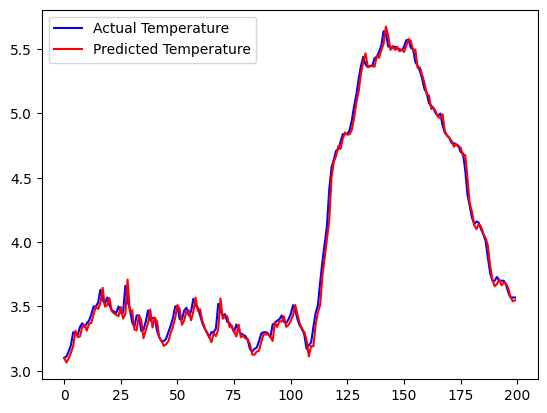

In [35]:
# @title 시각화
import matplotlib.pyplot as plt

test_targets = test_data[sequence_length:]

plt.plot(test_targets[:200], color='blue', label='Actual Temperature')
plt.plot(test_preds[:200], color='red', label='Predicted Temperature')
plt.legend()
plt.show()